# Домашнее задание 3.

_Vsevolod Suschevskiy_

Требуется реализовать модель фиксирующий ряд параметров в разложении матрицы (несколько наиболее популярных жанров, несколько наиболее популярных типов)
После построения разложения, используйте полученные разложения для кластеризации пользователей на 5-10 класстеров.
Попробуйте повторить построение разложения, но используя принадлежность к кластеру, как фиксированный элемент матрицы пользователя.
Стали ли прогнозы лучше?

In [1]:
from math import sqrt
from math import log2
from math import isnan

from random import random, seed
from collections import defaultdict
from itertools import islice

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ndcg_score
from sklearn.neighbors import NearestNeighbors

In [27]:
#Чтение данных
def loadMovieLens1M(path="C:\\Users\\wirze\\DataspellProjects\\recomend_hse\\week4-hw\\ml-1m",
                    genres = False):
    # Получить названия фильмов
    movies={}
    for line in open(path+'/movies.dat'):
        (id,title)=line.split('::')[0:2] #при желании тут можно добавить чтение жанров.
        movies[id]=title
    # Загрузить данные
    prefs={}
    if genres == False:
        for line in open(path+'/ratings.dat'):
            (user,movieid,rating,ts)=line.split('::')
            prefs.setdefault(user,{})
            prefs[user][movies[movieid]]=float(rating)
    else:
        for line in open(path+'/movies.dat'):
            (id, title, genre) = line.split('::')
            prefs.setdefault('genre', {})
            prefs['genre'][movies[id]] = genre.rstrip().split('|')
    return prefs

In [93]:
critics = loadMovieLens1M()
critics_df =  pd.DataFrame.from_dict(critics)
critics_df.head()

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
One Flew Over the Cuckoo's Nest (1975),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,5.0,NaN,5.0,5.0,4.0,NaN,NaN,4.0
James and the Giant Peach (1996),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
My Fair Lady (1964),3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Erin Brockovich (2000),4.0,NaN,NaN,NaN,3.0,5.0,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
"Bug's Life, A (1998)",5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN


In [94]:
genres = loadMovieLens1M(genres=True)

In [95]:
genres_df = pd.DataFrame.from_dict(genres)
genres_df.head()

,genre
"$1,000,000 Duck (1971)","[Children's, Comedy]"
'Night Mother (1986),[Drama]
'Til There Was You (1997),"[Drama, Romance]"
"'burbs, The (1989)",[Comedy]
...And Justice for All (1979),"[Drama, Thriller]"


In [90]:
genres_df_first = genres_df['genre'].apply(pd.Series)[0]
dummies_genres = pd.get_dummies(genres_df_first)
dummies_genres

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
"$1,000,000 Duck (1971)",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
'Night Mother (1986),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
'Til There Was You (1997),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
"'burbs, The (1989)",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...And Justice for All (1979),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Effect (1998),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Zero Kelvin (Kjærlighetens kjøtere) (1995),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Zeus and Roxanne (1997),0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Zone 39 (1997),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [119]:
critics_with_g = pd.merge(critics_df, dummies_genres,
                          left_index=True, right_index=True,
                          how = 'left')
critics_with_g = critics_with_g.reset_index().rename({'index': 'movie'}, axis='columns').reset_index()
critics_with_g

,index,movie,1,2,3,4,5,6,7,8,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,One Flew Over the Cuckoo's Nest (1975),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1,James and the Giant Peach (1996),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,My Fair Lady (1964),3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
3,3,Erin Brockovich (2000),4.0,NaN,NaN,NaN,3.0,5.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4,"Bug's Life, A (1998)",5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,3701,Modulations (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3702,3702,Broken Vessels (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3703,3703,White Boys (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3704,3704,One Little Indian (1973),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [125]:
movies_with_genres = pd.merge(critics_with_g, genres_df.reset_index().rename({'index': 'movie'}, axis='columns'),
         how = 'right').sort_values('index')
movies_with_genres

,index,movie,1,2,3,4,5,6,7,8,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre
2571,0.0,One Flew Over the Cuckoo's Nest (1975),5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[Drama]
1818,1.0,James and the Giant Peach (1996),3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Animation, Children's, Musical]"
2399,2.0,My Fair Lady (1964),3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Musical, Romance]"
1096,3.0,Erin Brockovich (2000),4.0,NaN,NaN,NaN,3.0,5.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[Drama]
577,4.0,"Bug's Life, A (1998)",5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Animation, Children's, Comedy]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3690,NaN,Vermin (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Comedy]
3691,NaN,Vermont Is For Lovers (1992),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Comedy, Romance]"
3729,NaN,War Stories (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Documentary]
3834,NaN,"Woman in Question, The (1950)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Mystery]


In [66]:
# Делим данные на train и test
# Для каждого пользователя 10 случайных оценок отправляем в test
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in np.arange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                        size=10,
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]

    # Проверяем, что   test и train не пересекаются
    assert(np.all((train * test) == 0))
    return train, test

In [65]:
# загружаем данные.
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('C:\\Users\\wirze\\DataspellProjects\\recomend_hse\\week4-hw\\ml-1m\\ratings.dat', sep='::',header=0, names=names, engine='python')
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

movie_recode = {}
current_next_free_movie_id = 0
original_movie_id = []

# Создаем r_{ui} - нашу матрицу оценок
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    if (row[2]) not in movie_recode:
        movie_recode[row[2]] = current_next_free_movie_id
        current_next_free_movie_id += 1
        original_movie_id.append(row[2])
    ratings[row[1]-1, movie_recode[row[2]]] = row[3]

In [158]:
filter_indices  = movies_with_genres['index'].values
filter_indices = filter_indices[~np.isnan(filter_indices)]
filter_indices = filter_indices.astype(int).tolist()
filter_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [199]:
mwg = movies_with_genres[movies_with_genres['index'].isin(filter_indices)]
# mwg
mwg = mwg[['index', 'genre']]
mwg =  mwg['genre'].apply(pd.Series)[0]
mwg = pd.get_dummies(mwg, columns=['genre'])
mwg = mwg.reset_index().drop(['index'], axis=1)
mwg
# np.array(mwg)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3702,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3703,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3704,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [159]:
ratings_cut = ratings[filter_indices]
ratings_cut

array([[3., 3., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 5., 3., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.]])

In [160]:
train, test= train_test_split(ratings_cut)

In [161]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [162]:
train

array([[3., 3., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.]])

In [261]:
from sklearn.metrics import mean_squared_error
from numpy.linalg import solve

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

class ExplicitMF():
    def __init__(self,
                 ratings,
                 fixed_vectors,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0,
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False,
                 fixed = False):
        """
        Train a matrix factorization model to predict empty
        entries in a matrix. The terminology assumes a
        ratings matrix which is ~ user x item

        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings

        n_factors : (int)
            Number of latent factors to use in matrix
            factorization model
        learning : (str)
            Method of optimization. Options include
            'sgd' or 'als'.

        item_fact_reg : (float)
            Regularization term for item latent factors

        user_fact_reg : (float)
            Regularization term for user latent factors

        item_bias_reg : (float)
            Regularization term for item biases

        user_bias_reg : (float)
            Regularization term for user biases

        verbose : (bool)
            Whether or not to printout training progress
        """

        self.ratings = ratings
        self.fixed_vectors = fixed_vectors
        self.fixed = fixed
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI),
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda

            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI),
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        if self.fixed == True:
            self.item_vecs = np.c_[self.item_vecs, np.array(self.fixed_vectors)]
            self.user_vecs = np.c_[self.user_vecs, np.array(self.fixed_vectors)]

        if self.learning == 'als':
            self.partial_train(n_iter,0)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter, 0)


    def partial_train(self, n_iter, iter_done):
        """
        Train model for n_iter iterations. Can be
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if (ctr+iter_done) % 10 == 0 and self._v:
                print (f'\tcurrent iteration: {ctr+iter_done}')
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs,
                                               self.item_vecs,
                                               self.ratings,
                                               self.user_fact_reg,
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs,
                                               self.user_vecs,
                                               self.ratings,
                                               self.item_fact_reg,
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            elif self.learning == 'sgd_2':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error

            # Update biases
            self.user_bias[u] += self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])

            # Update latent factors
            self.user_vecs[u, :self.n_factors] += self.learning_rate * (e * self.item_vecs[i, :self.n_factors] - self.user_fact_reg * self.user_vecs[u,:self.n_factors])
            self.item_vecs[i, :self.n_factors] += self.learning_rate * (e * self.user_vecs[u, :self.n_factors] - self.item_fact_reg * self.item_vecs[i,:self.n_factors])

            # if self.fixed == True:
            #     self.item_vecs = np.c_[self.item_vecs[:, :self.n_factors],
            #                            np.array(self.fixed_vectors)]

    def sgd_2(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            l = 0.3 # lambda
            e = (self.ratings[u,i] - prediction ) # error
            e = e + l * (e)**2

            # Update biases
            self.user_bias[u] += self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])

            #Update latent factors
            self.user_vecs[u, :self.n_factors] += self.learning_rate * \
                                                  (e * self.item_vecs[i, :self.n_factors] - self.user_fact_reg * self.user_vecs[u,:self.n_factors])
            self.item_vecs[i, :self.n_factors] += self.learning_rate * \
                                                  (e * self.user_vecs[u, :self.n_factors] - self.item_fact_reg * self.item_vecs[i,:self.n_factors])

    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction

    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0],
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)

        return predictions

    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.

        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).

        The function creates two new class attributes:

        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print (f'Iteration: {n_iter}')
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff, iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print (f'MSE train:test: {round(self.train_mse[-1],2)} : {round(self.test_mse[-1],2)}\n')
            iter_diff = n_iter

In [245]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse,
             label='Training', linewidth=3)
    plt.plot(iter_array, model.test_mse,
             label='Test', linewidth=3)

    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('Iterations', fontsize=25);
    plt.ylabel('MSE', fontsize=25);
    plt.legend(loc='best', fontsize=20);

In [77]:
MF_SGD = ExplicitMF(train, 100, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]

In [78]:
%%time
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
MSE train:test: 1.0 : 1.03

Iteration: 2
MSE train:test: 0.93 : 0.98

Iteration: 5
MSE train:test: 0.86 : 0.92

Iteration: 10
	current iteration: 10
MSE train:test: 0.83 : 0.89

Iteration: 25
	current iteration: 20
MSE train:test: 0.81 : 0.87

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 0.77 : 0.85

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 0.54 : 0.78

Wall time: 25min 34s


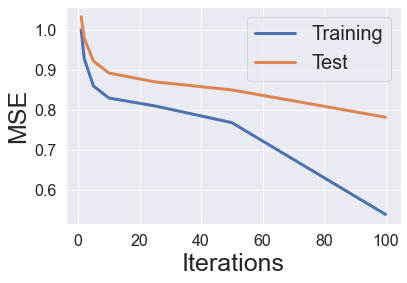

In [80]:
plot_learning_curve(iter_array, MF_SGD)

## fixed genres vectors

extracted genres from data, selected only the first genre for each movie,
than transformed this columns into dummies
and filter full dataset to have at least one genre

In [267]:
MF_SGD_fixed = ExplicitMF(train, fixed_vectors=mwg, n_factors=100, learning='sgd',
                          verbose=True, fixed=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]

In [268]:
%%time
MF_SGD_fixed.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
MSE train:test: 1.17 : 1.22

Iteration: 2
MSE train:test: 1.09 : 1.16

Iteration: 5
MSE train:test: 1.0 : 1.08

Iteration: 10
	current iteration: 10
MSE train:test: 0.95 : 1.04

Iteration: 25
	current iteration: 20
MSE train:test: 0.92 : 1.01

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 0.86 : 0.97

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 0.6 : 0.86

Wall time: 14min 16s


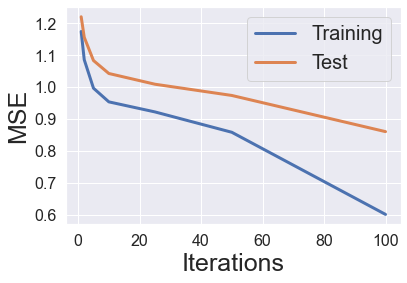

In [269]:
plot_learning_curve(iter_array, MF_SGD_fixed)

Так ну результаты модели ухудшились, причём как на тестовой, так и обучающей выборке, но ухудшение в границах ошибки, поэтому сказать что конец не могу.
По смыслу, кажется правильно включать жанры как dummy, а не как отскейленные integer, но получилось 18 "лишниих" эмбедингов для каждого фильма, а их ещё хранить и делать с ними операции
# user clust

In [220]:
user_emb = MF_SGD_fixed.user_vecs
user_emb

array([[-0.01031325,  0.01781589, -0.02573878, ...,  0.01595406,
         0.04113538,  0.0227105 ],
       [-0.12218029, -0.06272057, -0.025024  , ...,  0.10126878,
         0.02483664,  0.05107272],
       [-0.00878697,  0.07422984,  0.03171622, ...,  0.02454068,
         0.03855287,  0.01018661],
       ...,
       [ 0.05069957,  0.07416713, -0.0064359 , ..., -0.0039064 ,
        -0.05277969,  0.03612912],
       [-0.04033289, -0.03156939, -0.00053559, ..., -0.07114301,
        -0.09904472,  0.0066593 ],
       [-0.00276626, -0.03289176,  0.02302282, ..., -0.01461275,
        -0.08031424,  0.01577452]])

## clusters
i will use GM model , since I have tried it before and it is somewhat probabilistic,
and less common as k mean
but other than that choice is barely motivated

C:\Users\wirze\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\wirze\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\wirze\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


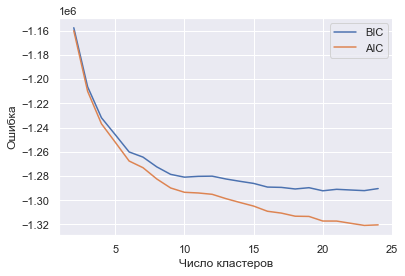

In [232]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(2, 25)
models_diff = [GaussianMixture(n, covariance_type='diag', random_state=0).fit(user_emb)
               for n in n_components]

plt.plot(n_components, [m.bic(user_emb) for m in models_diff], label='BIC')
plt.plot(n_components, [m.aic(user_emb) for m in models_diff], label='AIC')
plt.legend(loc='best')
plt.xlabel('Число кластеров')
plt.ylabel('Ошибка');

almost a plato after 10 clusters

In [233]:
gm_model = GaussianMixture(10, covariance_type='diag', random_state=0).fit(user_emb)
gm_model

GaussianMixture(covariance_type='diag', n_components=10, random_state=0)

In [271]:
user_clusts = gm_model.predict(user_emb)
user_clusts

array([8, 7, 8, ..., 9, 9, 3], dtype=int64)

## add clusters to model
clusters to dummies
and add them to model as fixed vects

In [272]:
uc = pd.get_dummies(user_clusts)
# uc = uc.reset_index().drop(['index'], axis=1)
uc

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
3701,0,0,1,0,0,0,0,0,0,0
3702,0,0,1,0,0,0,0,0,0,0
3703,0,0,0,0,0,0,0,0,0,1
3704,0,0,0,0,0,0,0,0,0,1


In [273]:
MF_SGD_fixed_clust = ExplicitMF(train, fixed_vectors=uc, n_factors=100, learning='sgd',
                          verbose=True, fixed=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]

In [274]:
%%time
MF_SGD_fixed_clust.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
MSE train:test: 1.11 : 1.17

Iteration: 2
MSE train:test: 1.03 : 1.11

Iteration: 5
MSE train:test: 0.95 : 1.05

Iteration: 10
	current iteration: 10
MSE train:test: 0.91 : 1.02

Iteration: 25
	current iteration: 20
MSE train:test: 0.88 : 0.99

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 0.85 : 0.97

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 0.63 : 0.9

Wall time: 14min 3s


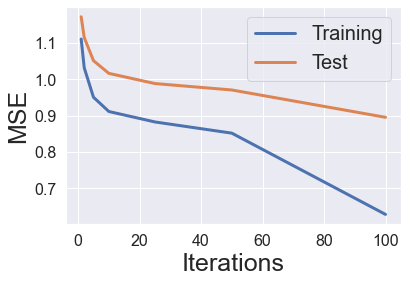

In [275]:
plot_learning_curve(iter_array, MF_SGD_fixed_clust)

Ну а с зафиксированными кластерами пользователей модель стала сильно быстрее сходиться, другое дело, что эти кластера, в некотором виде подглядывают в будущее и было бы правильнее обучать их только по данным обучающей выборки, а для тестовой предсказывать, но получилось неплохо, а главное я теперь уверен, что сделал задание, так как жанры давали слишком похожую модель на базовую модель


## conclustion

я не сделал регуляризацию, но добавил фиксированные вектора в модели, вытащил кластера пользователей и использовал принадлежность к кластеру в другой моделе

курс был не простой для понимания, но было прям приятно, когда после долгих часов копания понимал как сделать взвешивание, или зафиксировать часть эмбедингов

Будет сложно применить эти знания на практике, но для общего развития и для условного технического собеседования, думаю это сильно пригодится